In this notebook, we will demonstrate how `TableAutomization.py` can be used for different distributions, in this case the `banana` distribution provided by the cuqipy package.
Please note that a previous read on the `table-donut.ipynb` is suggested, as that notebook provides more detailed explanations on `TableAutomization.py`; moreover, there are comparisons between the two notebooks.

### Importing the needed libraries 

In [1]:
import cuqi
import numpy as np
import os
import sys
sys.path.append(os.path.abspath('..'))
from utilities import TableAutomization as TA
import benchmarksClass as BC 

# The banana distribution


In [2]:
# The banana distribution 
target_banana = BC.Banana()


### Plotting the "banana"

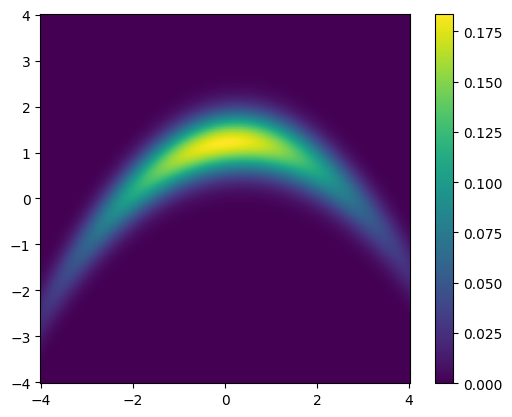

In [3]:
TA.plot_pdf_2D(target_banana, -4, 4, -4, 4)

- Compute sampling methods

In [4]:
true_mu = np.array([0, 0])
true_sigma = np.array([1,1])
y = cuqi.distribution.Gaussian(mean=true_mu, cov=true_sigma**2)

In [5]:
df, (fig, axs) = TA.create_comparison(target_banana, [1.0, 1.0, 0.065, 0.5, 0.1], 8500, 1500, x0 = y, seed = 12, chains=4)

Sample 10000 / 10000

Average acceptance rate: 0.372 

Sample 10000 / 10000

Average acceptance rate all components: 0.5456470588235294 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000

Average acceptance rate: 0.3790588235294118 

Sample 10000 / 10000

Average acceptance rate all components: 0.5360588235294117 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000

Average acceptance rate: 0.37423529411764705 

Sample 10000 / 10000

Average acceptance rate all components: 0.5422352941176471 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000

Average acceptance rate: 0.3827058823529412 

Sample 10000 / 10000

Average acceptance rate all components: 0.5509411764705883 

Sample 10000 / 10000
Sample 10000 / 10000
Sample 10000 / 10000


In [6]:
df

,MH,CWMH,ULA,MALA,NUTS
samples,8500,8500,8500,8500,8500
burnins,1500,1500,1500,1500,1500
scale,1.0,1.0,0.065,0.5,-
ESS(v0),109.889,50.421,31.378,75.038,232.147
ESS(v1),310.98,153.108,63.144,204.49,274.832
AR,0.372,0.637,1.0,0.507,0.744
LogPDF,10000,19999,10000,10000,42961
Gradient,0,0,10000,10000,42961
Rhat(v0),1.007,1.023,1.041,1.003,1.008
Rhat(v1),1.003,1.007,1.013,1.004,1.008


Observations:
- the  MH_fixed performs quite poorly, as ESS is very low, RHat strays from 1 and the AR is too high
- however, unlike in the donut distribution, the MH_adapted, performs better than expected, with Rhat close to 1.0 (converges well) and ESS, especially ESS(v1), is quite high 
- ULA has acceptence rate AR=1.0, as expected, and it performs well, with ESS parameters not too high but higher than MH, also R_hat is close to 1, meaing that it converges well enough
- MALA performs decently, but NUTS outperforms all the methods, but the computational costs are at least 4 times higher

- Create distribution images  

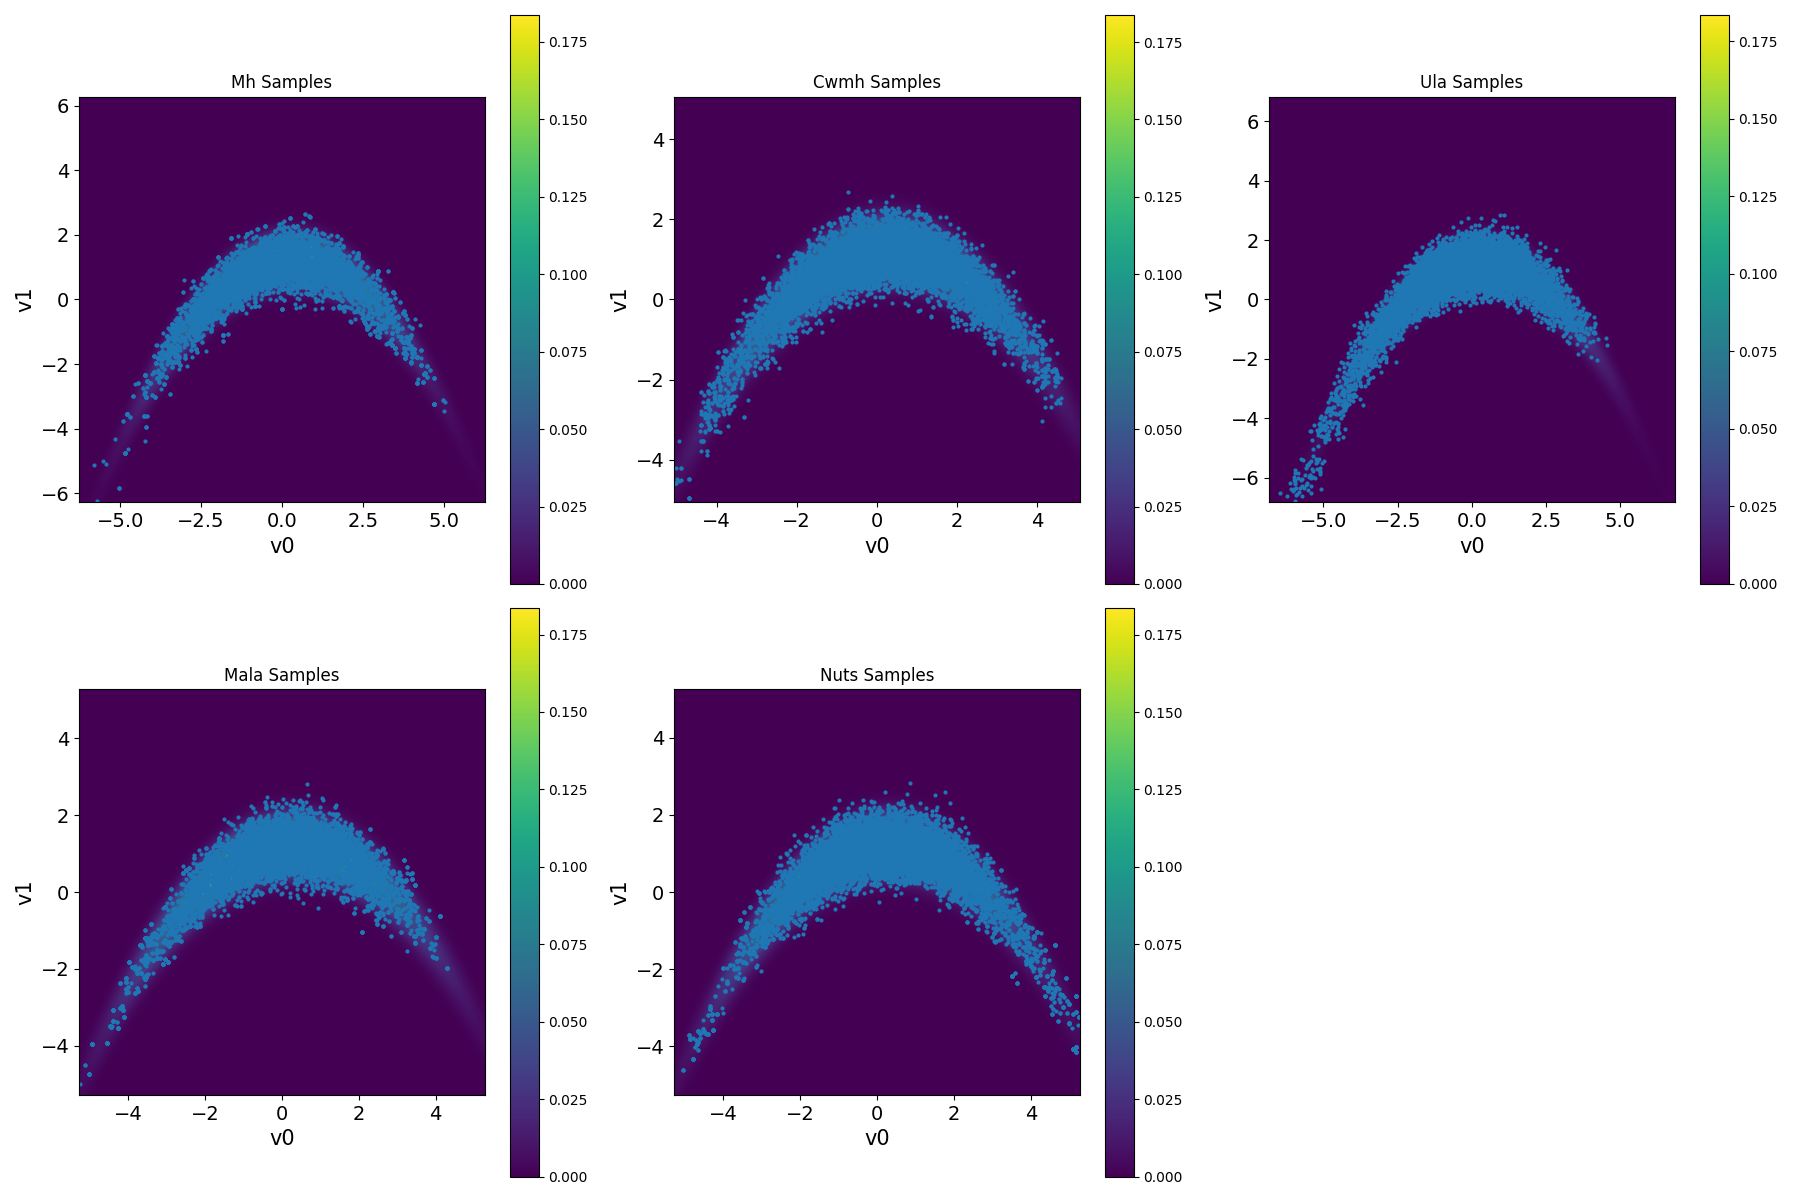

In [7]:
TA.show_plot(fig)

_Observations_
- as expected the MH_fixed stays quite close to the initial point  
- compared to the previous graphss,it can be seen that setting a relatively high number of burn ins will lead to better results 